# Timeseries modeling of sunspots dataset

My attempt to create a timeseries model of the inbuilt sunspots dataset from R.

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
import statsmodels.api as sm

In [238]:
df = pd.DataFrame(sm.datasets.sunspots.load_pandas().data)
df['sunspots'] = MinMaxScaler().fit_transform(np.array(df['SUNACTIVITY']).reshape(-1, 1))
df['year'] = pd.to_datetime([f'01-01-{int(year)}' for year in df['YEAR']])
df.drop(['YEAR', 'SUNACTIVITY'], axis=1, inplace=True)
df

,sunspots,year
0,0.026288,1700-01-01
1,0.057834,1701-01-01
2,0.084122,1702-01-01
3,0.120925,1703-01-01
4,0.189274,1704-01-01
...,...,...
304,0.212408,2004-01-01
305,0.156677,2005-01-01
306,0.079916,2006-01-01
307,0.039432,2007-01-01


## Visualization

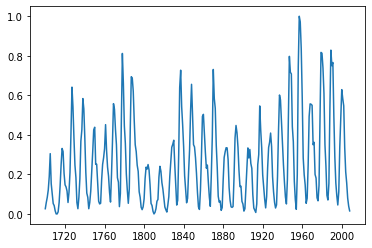

In [209]:
plt.plot(df['year'], df['sunspots'])

Plot showing the number of sunspots each year. There is definitely autocorrelation, and it looks like there might be a seasonal component on the scale of a few years. Let's explore these further.

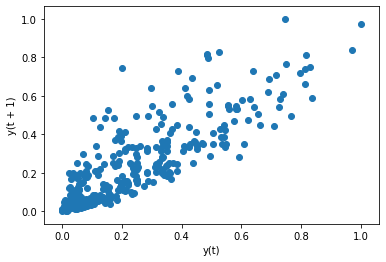

In [210]:
pd.plotting.lag_plot(df['sunspots'])

This lag plot shows the relationship between each value for sunspots and the value for the next year. You can see that they are highly correlated, although the relationship looks pretty heteroscedatic. This bodes well for tsa in general but poorly for autoregression.

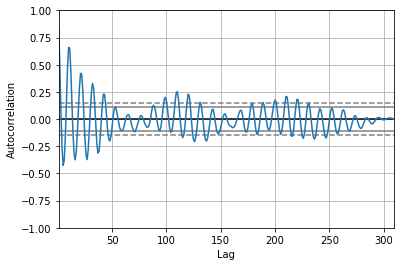

In [211]:
pd.plotting.autocorrelation_plot(df['sunspots'])

Another visualization of autocorrelation. Here, pearson's r is plotted as a function of lag. So, at y=100, the blue line will show the correlation between each value and the value from 100 years earlier.

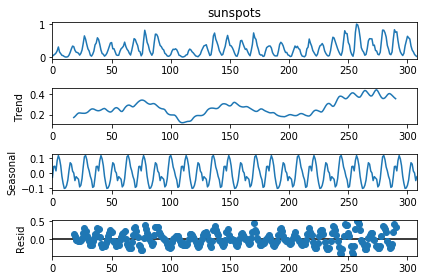

In [312]:
seasons_decompose = sm.tsa.seasonal_decompose(df['sunspots'], model='additive', period=36) #parameters=hunch
seasons_decompose.plot()
plt.show()

This plot shows a seasonal decomposition with a seasonality of three years. This is helpful because it shows that, once the seasonal component is removed, we get a clear, relatively simple trend and apparently random residuals.

## Autoregression Model

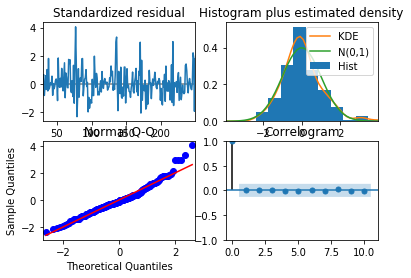

In [223]:
ar_model = sm.tsa.AutoReg(df['sunspots'].iloc[:250], trend='t', lags=30)
ar_results = ar_model.fit()

ar_results.plot_diagnostics()
plt.show()

These look generally okay. The Q-Q plot is a little disheartening, since it appears that the model is bad at predicting particularly high values of sunspots. However, it's fine for normal values. Also, it's not totally clear, but it looks like there might be a downward trend in the residuals.

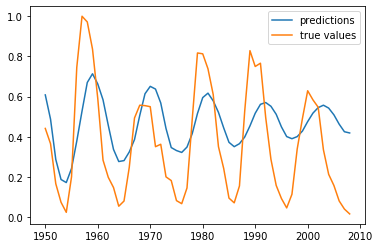

(0.6359240083860759, 6.232457438780133e-08)

In [244]:
df['ar_predictions'] = ar_model.predict(ar_results.params, end=309)

plt.plot(df['year'].iloc[250:], df['ar_predictions'].iloc[250:], label='predictions')
plt.plot(df['year'].iloc[250:], df['sunspots'].iloc[250:], label='true values')
plt.legend()
plt.show()

stats.pearsonr(df['ar_predictions'].iloc[250:], df['sunspots'].iloc[250:])

This plot shows forecasts made in 1950 for the remainder of the dataset. Although the model is getting the general idea of the trend, it's guesses are insifficiently extreme. The fact that the parameters are underconfidenct like this suggests that there might be some irregularity in the trend or else several outliers.

At 0.63, r is good for such a simple model.

## ARMA Model

/Users/leoware/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


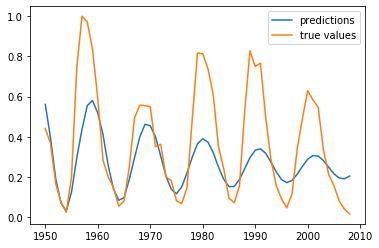

(0.7752271373953188, 5.706171093977972e-13)

In [248]:
arma_model = sm.tsa.ARMA(df['sunspots'].iloc[:250], order=(10, 3))
arma_results = arma_model.fit()

df['arma_predictions'] = arma_model.predict(arma_results.params, start=0, end=308)

plt.plot(df['year'].iloc[250:], df['arma_predictions'].iloc[250:], label='predictions')
plt.plot(df['year'].iloc[250:], df['sunspots'].iloc[250:], label='true values')
plt.legend()
plt.show()

stats.pearsonr(df['arma_predictions'].iloc[250:], df['sunspots'].iloc[250:])

This module does not supoport the diagnostic plots that the autoregressor does, but we can still see visually that the moving averge compinent was successful at aligning the predicted trend more accurately with the real one. The model is still underconfident in that the predictions, especially the high ones, are insufficiently extreme, but, on the whole, it is really quite good, especially in the years immediately after the forecast.

## SARIMA Model

The SARIMA model adds two components to the ARMA model. First, it models the seasonality of the variable itself as a ARMA process, controlling for this much more effectively. Also, it "differences" the values of the function, predicting changes rather than absolute values--a trick that helps prevent interference from the trend.

Optimization terminated successfully.
         Current function value: -1.193958
         Iterations: 23
         Function evaluations: 4319


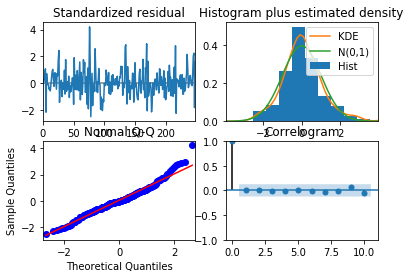

In [313]:
sarima_model = sm.tsa.SARIMAX(df['sunspots'].iloc[:250], order=(5, 1, 3), seasonal_order=(3, 0, 3, 12))
sarima_results = sarima_model.fit(method='powell')

sarima_results.plot_diagnostics()
plt.show()

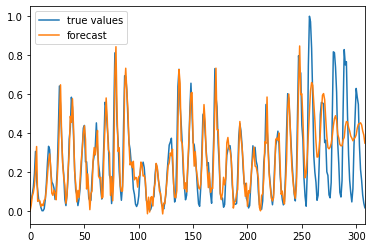

In [335]:
plt.plot(df['sunspots'], label='true values')

sarima_predictions = sarima_results.get_prediction(start=0, end=308)
sarima_predictions.predicted_mean.plot(label='forecast')

plt.legend()
plt.show()

This module still doesn't support everything that I used in the other models, but you can still see in this plot the same general behavior from the previous models. The model understands the general idea of the seasonality and trend, but it is not properly aligned with the true values, and it quickly diminishes in confidence for unclear reasons.